# DWM (Dynamic Weighted Majority)

In this notebook the algorithm DWM for concept drift handleling is implemented.

## Dependencies

In [232]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy
import matplotlib.pyplot as plt

## STAGGER Concepts

The STAGGER concepts constitute a way of creating a streaming dataset to evaluate the response of an algortihm to concept drift.

It includes three attributes with 3 values per asttribute. The strategy is to label as True or False different combinations of attributes in sucessive time slots to evaluate the performance.

* **Attributes:**
    - ***Color:*** Green, blue and red.
    - ***Shape:*** Triangle, circle and rectangle.
    - ***Size:*** Small, medium and large.
    
The presentation of training examples lasts for 120 time steps, and at each time step, the learner receives one example. For the first 40 time steps, the target concept is color = red ∧ size = small. During the next 40 time steps, the target concept is color = green ∨ shape = circle. Finally, during the last 40 time steps, the target concept is size = medium ∨ size = large. A visualization of these concepts.

To evaluate the learner, at each time step, one randomly generates 100 examples of the current target concept, presents these to the performance element, and computes the percent correctly predicted. In our experiments, we repeated this procedure 50 times and averaged the accuracies over these runs. We also computed 95% confidence intervals.

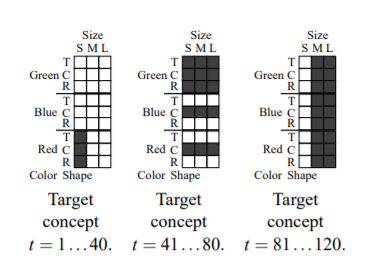

In [2]:
from IPython.display import Image
Image("stagger.png")

In [112]:
# Returns a dataframe with a specified 'number' of elements with random values for each attribute among the specified values.
# The label is calculated depending on the time
def gen_example(number, time):
    attr = {'color' : ['Red', 'Green', 'Blue'],
            'shape' : ['Triangle', 'Circle', 'Rectangle'],
            'size' : ['Small', 'Medium', 'Large']}
    # Define lists
    color_list = []
    shape_list = []
    size_list = []
    label_list = []
    # Loop to create the required data n
    for n in range(number):
        color_list.append(attr['color'][np.random.randint(len(attr['color']))])
        shape_list.append(attr['shape'][np.random.randint(len(attr['shape']))])
        size_list.append(attr['size'][np.random.randint(len(attr['size']))])
        if(time < 40):
            if(color_list[n] == 'Red' and size_list[n] == 'Small'):
                label_list.append(1)
            else:
                label_list.append(0)
        elif(40 <= time and time < 80):
            if(color_list[n] == 'Green' or shape_list[n] == 'Circle'):
                label_list.append(1)
            else:
                label_list.append(0)
        else:
            if(size_list[n] == 'Medium' or size_list[n] == 'Large'):
                label_list.append(1)
            else:
                label_list.append(0)
    # Build dict            
    data = {'color' : color_list,
            'shape' : shape_list,
            'size' : size_list,
            'label' : label_list}
    # Build dataframe
    df = pd.DataFrame(data, columns = ['color', 'shape', 'size', 'label'])
    # returns data frame
    df = pd.get_dummies(df, prefix=['color', 'shape', 'size'], columns=['color', 'shape', 'size'])
    return df
    

In [69]:
df = gen_example(100, 10)
df

,color,shape,size,label
0,Green,Rectangle,Medium,0
1,Green,Circle,Medium,0
2,Blue,Triangle,Small,0
3,Green,Circle,Medium,0
4,Green,Circle,Medium,0
5,Red,Triangle,Small,1
6,Red,Triangle,Large,0
7,Blue,Triangle,Large,0
8,Green,Rectangle,Small,0
9,Red,Triangle,Small,1


## Dwm Implementation


* **Concept Drift:** It is the phenomena in which the label of data instances shifts over time, i.e., two similar samples will have different label depending on the time.

* **Ensemble Methods:** It is the method in which several learnes are used to train different classifiers to later predict the class label based on a voting or weighted approach.

    * *Bagging*
    * *Boosting*
    * *Stacking*
    
**<font color=blue>DWM algorithm</font>**

* ***Description:***

    - The formal algorithm for DWM appears in Figure 1. The algorithm maintains a set of m experts, E, each with a weight, wi for i = 1,...,m. Input to the algorithm is n training examples, each consisting of a feature vector and a class label. The parameters also include the number of classes(c) and β, a multiplicative factor that DWM uses to decrease an expert’s weight when it predicts incorrectly. A typical value for β is 0.5. The parameter θ is a threshold for removing poorly performing experts. If an expert’s weight falls below this threshold, then DWM removes it from the ensemble. Finally, the parameter p determines how often DWM creates and removes experts. We found this parameter useful and necessary for large or noisy problems, which we discuss further inSection 4.2. In the following discussion, we assume p = 1. 
    
    - DWM begins by creating an ensemble containing a single learner with a weight of one (lines 1–3 of Figure 1). Initially, this learner could predict a default class, or it could predict using previous experience, background knowledge, or both. DWM then takes a single example (or perhaps a set ofexamples) from the stream and presents it to the single learner to classify (line 7). If the learner’s prediction is wrong (line 8), then DWM decreases the learner’s weight by multiplying it by β (line 9). Since there is one expert in the ensemble, its prediction is DWM’s global prediction (lines 12 and 24). 
    
    - If DWM’s global prediction is incorrect (line 16), then it creates a new learner with a weight of one (lines 17–19). DWM then trains the experts in the ensemble on the new example (line 23). After training, DWM outputs its global prediction (line 24). When there are multiple learners, DWM obtains a classification from each member of the ensemble (lines 6 and 7). If one’s prediction is incorrect, then DWM decreases its weight (lines 8 and 9). Regardless of the correctness of the prediction, DWM uses each learner’s prediction and its weight to compute a weighted sum for each class (line 10). The class with the most weight is set as the global prediction (line 12). 
    
    - Since DWM always decreases the weights of experts, it normalizes the weights by scaling them uniformly so that, after the transformation, the maximum weight is one (line 14). This prevents newly added experts from dominating predictions. DWM also removes poorly performing experts by removing those with a weight less than the threshold θ (line 15), although it will not remove the last expert in the ensemble. As mentioned previously, if the global prediction is incorrect (line 16), DWM adds a new expert to the ensemble with a weight of one (lines 17–19). Finally, after using the new example to train each learner in the ensemble (lines 22 and 23), DWM outputs the global prediction, which is the weighted vote of the expert predictions (line 24).
    
    - As mentioned previously, the parameter p lets DWM better cope with many or noisy examples. p defines the period over which DWM will not update learners’ weights (line 8) and will not remove or create experts (line 13). During this period, however, DWM still trains the learners (lines 22 and 23).
    
    - DWM is a general algorithm for coping with concept drift. One can use any online learning algorithm as the base learner. To date, we have evaluated two such algorithms, naive Bayes and Incremental Tree Inducer, and we describe these versions in the next two sections.

 
* ***Elements:***

    - m: Number of experts
    - E: Expert
    - wj: Expert's weight
    - n: Input training samples
    - c: number of classes
    - β: decreasing weight factor (0 ≤ β < 1)
    - θ: Removing learner weight threshold
    - p: How often DWM removes or update weights
    - Λ,λ ∈ {1,..., c}: global and local predictions


* ***Algorithm:***

    / 1. m ← 1

    / 2. em ← Create-New-Expert()

    / 3. wm ← 1

    / 4. for i ← 1,...,n // Loop over examples

        / 5. ~σ ← 0

        / 6. for j ← 1,...,m // Loop over experts

            / 7. λ ← Classify(e j,~xi)

            / 8. if (λ 6= yi and i mod p = 0)

                / 9. wj ← βwj

            / 10. σλ ← σλ +wj

        / 11. end;

        / 12. Λ ← argmaxj σj

        / 13. if (i mod p = 0)

            / 14. w ← Normalize-Weights(w)

            / 15. {e,w} ← Remove-Experts({e,w},θ)

            / 16. if (Λ 6= yi)

                / 17. m ← m+1

                / 18. em ← Create-New-Expert()

                / 19. wm ← 1

            / 20. end;

        / 21. end;

        / 22. for j ← 1,...,m

            / 23. e j ← Train(e j,~xi, yi)

            / 24. output Λ

        end;

    end

In [127]:
df = gen_example(100,0)
df.iloc[0]

label              0
color_Blue         1
color_Green        0
color_Red          0
shape_Circle       1
shape_Rectangle    0
shape_Triangle     0
size_Large         0
size_Medium        1
size_Small         0
Name: 0, dtype: int64

In [133]:
df.to_numpy()[0][1:len(df.to_numpy()[0])]

array([1, 0, 0, 1, 0, 0, 0, 1, 0], dtype=int64)

In [ ]:
# Como inizializar para predecir la primera vez??
# df.get_dummies automatically (that is not necessary to generate 100 samples to count with all the columns)

In [142]:
np.array([1, 2, 3])

array([1, 2, 3])

In [148]:
def norm_weights(w):
    maximum = w[0]
    for i in range(1,len(w)):
        if maximum < w[i]:
            maximum = w[i]
    for i in range(len(w)):
        w[i] = w[i] / maximum
    return w

In [187]:
def remove_experts(E, w, theta, m):
    list_E = []
    list_w = []
    for i in range(len(w)):
        if w[i] >= theta:
            list_E.append(E[i])
            list_w.append(w[i])
        else:
            print('Deleted:' + str(i))
            m = m - 1
    return list_E, list_w, m

In [244]:
# Initialize number of classifiers to 1
m = 1
# Examples presented
n = 120
# Number of classes
c = 2
# Beta factor for decreasing weight
beta = 0.5
# Theta factor
theta = 0.01
# Create first classifier and weight
E = []
E.append(MultinomialNB())
E[0].partial_fit(np.random.randint(2, size = (1,9)), np.array([1]), classes = [0,1])
w = []
Y = []
accuracy = []
elements = []
w.append(1)
for i in range(n):
    df = gen_example(100,i)
    # Generate 100 samples 1 for training 99 for testing
    x_train = df.to_numpy()[0][1:len(df.to_numpy()[0])]
    x_test = df.to_numpy()[1:100][:,1:len(df.to_numpy()[0])]
    y_train = df.to_numpy()[0][0]
    y_test = df.to_numpy()[1:100][:,0]
    # Create the predition array
    local_pred = np.array(np.zeros(c))
    for j in range(m):
        y_pred = E[j].predict(np.array(x_train, ndmin = 2))
        if(y_pred != y_train):
            w[j] = w[j] * beta
        local_pred[E[j].predict(np.array(x_train, ndmin = 2))] = local_pred[E[j].predict(np.array(x_train, ndmin = 2))] + w[j]
    global_pred = np.argmax(local_pred)
    local_pred_test = np.zeros((x_test.shape[0], c))
    for j in range(m):
        y_pred = E[j].predict(x_test)
        for k in range(local_pred_test.shape[0]):
            local_pred_test[k][y_pred[k]] = local_pred_test[k][y_pred[k]] + w[j]
    global_pred_test = np.argmax(local_pred_test, axis=1)
    accuracy.append(accuracy_score(y_test, global_pred_test))
    w = norm_weights(w)
    #print('Example: ' + str(i))
    #print('B:' + str(len(w)))
    elements.append(m)
    E, w, m = remove_experts(E, w, theta, m)
    #print('A:' + str(len(w)))
    if(global_pred != y_train):
        m = m + 1
        E.append(MultinomialNB())
        w.append(1)
    
    for j in range(m):
        E[j].partial_fit(np.array(x_train, ndmin = 2), np.array(y_train, ndmin = 2), classes = [0,1])
    Y.append(global_pred)

Deleted:2
Deleted:3
Deleted:0
Deleted:1
Deleted:5
Deleted:1
Deleted:2
Deleted:4
Deleted:1
Deleted:0


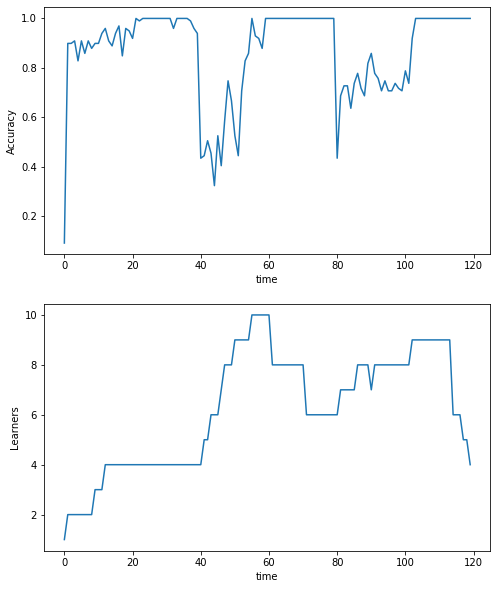

In [245]:
plt.figure(figsize=(8,10))

plt.subplot(2,1,1)
plt.plot(accuracy)
plt.ylabel('Accuracy')
plt.xlabel('time')

plt.subplot(2,1,2)
plt.plot(elements)
plt.ylabel('Learners')
plt.xlabel('time')

plt.show()